# SmoothQuant Activation Visualization for LLaDA

This notebook visualizes the differences in activations between the original LLaDA model and the SmoothQuant-processed model. We compare activation distributions before and after applying the smoothing transformation to understand how SmoothQuant improves quantization-friendliness.

In [1]:
import os
import sys
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple, Optional
from collections import defaultdict

# Add parent directory to path for imports
sys.path.insert(0, os.path.dirname(os.path.abspath('.')))

# Model imports
from model.modeling_llada import LLaDAModelLM
from transformers import AutoTokenizer

# SmoothQuant imports
from smoothquant.smoothquant_llada import apply_smoothquant_pipeline, get_llada_blocks
from smoothquant.quantize import quantize_tensor

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print("Imports complete!")

/home/joshuaz/dllm/Fast-dLLM/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Imports complete!


In [10]:
act_scales = torch.load("act_scales/LLaDA-8B-Instruct.pt")
act_scales.keys()

dict_keys(['model.transformer.blocks.0.q_proj', 'model.transformer.blocks.0.k_proj', 'model.transformer.blocks.0.v_proj', 'model.transformer.blocks.0.attn_out', 'model.transformer.blocks.0.ff_proj', 'model.transformer.blocks.0.up_proj', 'model.transformer.blocks.0.ff_out', 'model.transformer.blocks.1.q_proj', 'model.transformer.blocks.1.k_proj', 'model.transformer.blocks.1.v_proj', 'model.transformer.blocks.1.attn_out', 'model.transformer.blocks.1.ff_proj', 'model.transformer.blocks.1.up_proj', 'model.transformer.blocks.1.ff_out', 'model.transformer.blocks.2.q_proj', 'model.transformer.blocks.2.k_proj', 'model.transformer.blocks.2.v_proj', 'model.transformer.blocks.2.attn_out', 'model.transformer.blocks.2.ff_proj', 'model.transformer.blocks.2.up_proj', 'model.transformer.blocks.2.ff_out', 'model.transformer.blocks.3.q_proj', 'model.transformer.blocks.3.k_proj', 'model.transformer.blocks.3.v_proj', 'model.transformer.blocks.3.attn_out', 'model.transformer.blocks.3.ff_proj', 'model.trans

## Configuration

In [2]:
# ============================================
# Configuration
# ============================================

# Model configuration
MODEL_PATH = "GSAI-ML/LLaDA-8B-Instruct"

# Device configuration
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DTYPE = torch.bfloat16

# Target layers for visualization
# Format: (block_index, layer_name)
TARGET_LAYERS = [
    (27, "attn_out"),   # Attention output projection
    (27, "ff_out"),     # Feedforward output projection
    (27, "q_proj"),     # Query projection
    (27, "v_proj"),     # Value projection
    (27, "ff_proj"),    # Feedforward gate projection
]

# SmoothQuant configuration
ALPHA = 0.5              # Migration strength (0.5 = balanced)
CALIBRATION_SAMPLES = 32  # Reduced for faster testing
SEQ_LEN = 256            # Sequence length for test input

# Visualization settings
FIGURE_DPI = 100
HIST_BINS = 100

print(f"Device: {DEVICE}")
print(f"Model: {MODEL_PATH}")
print(f"Target layers: {TARGET_LAYERS}")

Device: cuda
Model: GSAI-ML/LLaDA-8B-Instruct
Target layers: [(27, 'attn_out'), (27, 'ff_out'), (27, 'q_proj'), (27, 'v_proj'), (27, 'ff_proj')]


## Load Original Model (Without SmoothQuant)

In [3]:
# Load the original model (without any smoothing or quantization)
print("Loading original model...")

original_model = LLaDAModelLM.from_pretrained(
    MODEL_PATH,
    torch_dtype=DTYPE,
    device_map=DEVICE,
    trust_remote_code=True,
)
original_model.eval()

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH, trust_remote_code=True)

print(f"Original model loaded successfully!")
print(f"Model dtype: {next(original_model.parameters()).dtype}")
print(f"Model device: {next(original_model.parameters()).device}")

`torch_dtype` is deprecated! Use `dtype` instead!


Loading original model...
2.9.1+cu130


/home/joshuaz/dllm/Fast-dLLM/venv/lib/python3.12/site-packages/torch/cuda/__init__.py:284: UserWarning: 
    Found GPU0 NVIDIA GB10 which is of cuda capability 12.1.
    Minimum and Maximum cuda capability supported by this version of PyTorch is
    (8.0) - (12.0)
    
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 6/6 [00:26<00:00,  4.42s/it]


Original model loaded successfully!
Model dtype: torch.bfloat16
Model device: cuda:0


In [11]:
from model.modeling_llada import LayerNormBase
target_types = (nn.Linear, nn.LayerNorm, nn.Conv1d, nn.Conv2d, nn.Embedding)
for name, module in original_model.named_modules():
    if isinstance(module, target_types):
        if hasattr(module, 'bias') and module.bias is not None:
            print(f"Bias found for {name}")
        else:
            # print(f"No bias found for {name}")
            pass




## Load SmoothQuant Model

Apply the SmoothQuant pipeline to create a smoothed model. We use `skip_quantization=True` to only apply the smooth transformation without replacing linear layers with quantized versions. This allows us to fairly compare activations between the original and smoothed models.

In [8]:
# Apply SmoothQuant pipeline to create a smoothed model
# Note: skip_quantization=True means we only apply smoothing, not quantization
# This allows for fair activation comparison

print("Applying SmoothQuant pipeline...")

smoothquant_model, act_scales = apply_smoothquant_pipeline(
    model_path=MODEL_PATH,
    calibration_samples=CALIBRATION_SAMPLES,
    alpha=ALPHA,
    w_bits=8,
    a_bits=8,
    seq_len=SEQ_LEN,
    batch_size=1,
    device=DEVICE,
    skip_quantization=True,  # Only smooth, don't quantize for fair comparison
)

print(f"\nSmoothQuant model loaded!")
print(f"Number of activation scales collected: {len(act_scales)}")

Applying SmoothQuant pipeline...

SmoothQuant Pipeline for LLaDA
Model: GSAI-ML/LLaDA-8B-Instruct
Alpha: 0.5
Quantization: W8A8
Calibration samples: 32
Device: cuda

[Step 1/4] Loading model...


Loading checkpoint shards: 100%|██████████| 6/6 [00:29<00:00,  4.94s/it]


  Model loaded successfully

[Step 2/4] Collecting activation scales...
Building Calibration Buffer with Mask ID: 126336...
Concatenating and tokenizing dataset...
Total tokens in concatenated dataset: 2608998
Calibration Dataset Ready: 32 tensors.
  Registered hooks on 225 Linear layers
Running calibration on batch size 1


  Calibration: 100%|██████████| 32/32 [00:10<00:00,  3.16it/s]


  Collected activation scales for 225 layers

[Step 3/4] Applying SmoothQuant transformations...
  Applying SmoothQuant with alpha=0.5 to 32 blocks...
    Processed 10/32 blocks
    Processed 20/32 blocks
    Processed 30/32 blocks
    Processed 32/32 blocks

[Step 4/4] Skipping quantization (skip_quantization=True)

SmoothQuant Pipeline Complete


SmoothQuant model loaded!
Number of activation scales collected: 225


## Create Test Input Data

Generate test inputs that we'll use to capture activations from both models.

In [9]:
# Create test input using a sample prompt
# For LLaDA, we also apply some masking to simulate the diffusion process

test_prompt = """The quick brown fox jumps over the lazy dog. This is a test sentence 
to analyze how SmoothQuant affects the activation distributions in the LLaDA model.
Machine learning models often have outlier activations that make quantization difficult.
SmoothQuant addresses this by migrating quantization difficulty from activations to weights."""

# Tokenize the input
encoded = tokenizer(
    test_prompt,
    return_tensors='pt',
    padding='max_length',
    max_length=SEQ_LEN,
    truncation=True,
)
test_input_ids = encoded.input_ids.to(DEVICE)

# Get the mask token id for LLaDA
if hasattr(tokenizer, "mask_token_id") and tokenizer.mask_token_id is not None:
    mask_token_id = tokenizer.mask_token_id
else:
    mask_token_id = 126336  # Default for LLaDA

# Apply partial masking to simulate LLaDA's input (50% masking)
mask_ratio = 0.5
num_tokens = test_input_ids.shape[1]
num_mask = int(num_tokens * mask_ratio)
mask_indices = torch.randperm(num_tokens)[:num_mask]

masked_input_ids = test_input_ids.clone()
masked_input_ids[0, mask_indices] = mask_token_id

print(f"Test input shape: {masked_input_ids.shape}")
print(f"Number of masked tokens: {num_mask} / {num_tokens} ({mask_ratio*100:.0f}%)")

Test input shape: torch.Size([1, 256])
Number of masked tokens: 128 / 256 (50%)


## Activation Capture Utilities

Define hook functions to capture activations at specific layers during forward pass.

In [6]:
def create_activation_hook(storage: Dict[str, torch.Tensor], name: str):
    """
    Create a forward hook that captures the input activations to a layer.
    
    Args:
        storage: Dictionary to store captured activations
        name: Name/key to use for storing the activation
    
    Returns:
        Hook function
    """
    def hook(module: nn.Module, input: Tuple[torch.Tensor, ...], output: torch.Tensor):
        x = input[0] if isinstance(input, tuple) else input
        storage[name] = x.detach().cpu().clone()
    return hook


def register_activation_hooks(
    model: nn.Module, 
    target_layers: List[Tuple[int, str]],
    storage: Dict[str, torch.Tensor]
) -> List[torch.utils.hooks.RemovableHandle]:
    """
    Register activation hooks on specified layers of the model.
    
    Args:
        model: The LLaDA model
        target_layers: List of (block_index, layer_name) tuples
        storage: Dictionary to store captured activations
    
    Returns:
        List of hook handles for later removal
    """
    hooks = []
    blocks = get_llada_blocks(model)
    
    for block_idx, layer_name in target_layers:
        if block_idx >= len(blocks):
            print(f"Warning: Block {block_idx} not found (model has {len(blocks)} blocks)")
            continue
            
        block = blocks[block_idx]
        
        if not hasattr(block, layer_name):
            print(f"Warning: Layer '{layer_name}' not found in block {block_idx}")
            continue
        
        layer = getattr(block, layer_name)
        hook_name = f"block{block_idx}_{layer_name}"
        hook = layer.register_forward_hook(create_activation_hook(storage, hook_name))
        hooks.append(hook)
        print(f"Registered hook: {hook_name}")
    
    return hooks


def remove_hooks(hooks: List[torch.utils.hooks.RemovableHandle]):
    """Remove all registered hooks."""
    for hook in hooks:
        hook.remove()
    print(f"Removed {len(hooks)} hooks")


print("Activation capture utilities defined!")

Activation capture utilities defined!


## Capture Activations from Both Models

Run forward passes on both models and capture activations at the target layers.

In [7]:
# Storage for captured activations
original_activations: Dict[str, torch.Tensor] = {}
smoothquant_activations: Dict[str, torch.Tensor] = {}

# Capture activations from original model
print("Capturing activations from original model...")
original_hooks = register_activation_hooks(original_model, TARGET_LAYERS, original_activations)

with torch.no_grad():
    _ = original_model(input_ids=masked_input_ids)

remove_hooks(original_hooks)
print(f"Captured {len(original_activations)} activations from original model\n")

# Capture activations from SmoothQuant model
print("Capturing activations from SmoothQuant model...")
smoothquant_hooks = register_activation_hooks(smoothquant_model, TARGET_LAYERS, smoothquant_activations)

with torch.no_grad():
    _ = smoothquant_model(input_ids=masked_input_ids)

remove_hooks(smoothquant_hooks)
print(f"Captured {len(smoothquant_activations)} activations from SmoothQuant model\n")

# Display captured layer names
print("Captured layers:")
for name in original_activations.keys():
    orig_shape = original_activations[name].shape
    sq_shape = smoothquant_activations[name].shape
    print(f"  {name}: original={orig_shape}, smoothquant={sq_shape}")

Capturing activations from original model...
Registered hook: block27_attn_out
Registered hook: block27_ff_out
Registered hook: block27_q_proj
Registered hook: block27_v_proj
Registered hook: block27_ff_proj
Removed 5 hooks
Captured 5 activations from original model

Capturing activations from SmoothQuant model...
Registered hook: block27_attn_out
Registered hook: block27_ff_out
Registered hook: block27_q_proj
Registered hook: block27_v_proj
Registered hook: block27_ff_proj
Removed 5 hooks
Captured 5 activations from SmoothQuant model

Captured layers:
  block27_q_proj: original=torch.Size([1, 256, 4096]), smoothquant=torch.Size([1, 256, 4096])
  block27_v_proj: original=torch.Size([1, 256, 4096]), smoothquant=torch.Size([1, 256, 4096])
  block27_attn_out: original=torch.Size([1, 256, 4096]), smoothquant=torch.Size([1, 256, 4096])
  block27_ff_proj: original=torch.Size([1, 256, 4096]), smoothquant=torch.Size([1, 256, 4096])
  block27_ff_out: original=torch.Size([1, 256, 12288]), smooth

## Visualization 1: Activation Distribution Histograms

Compare the distribution of activation values before and after SmoothQuant. The goal is to see how SmoothQuant reduces outliers and makes the distribution more uniform/quantization-friendly.

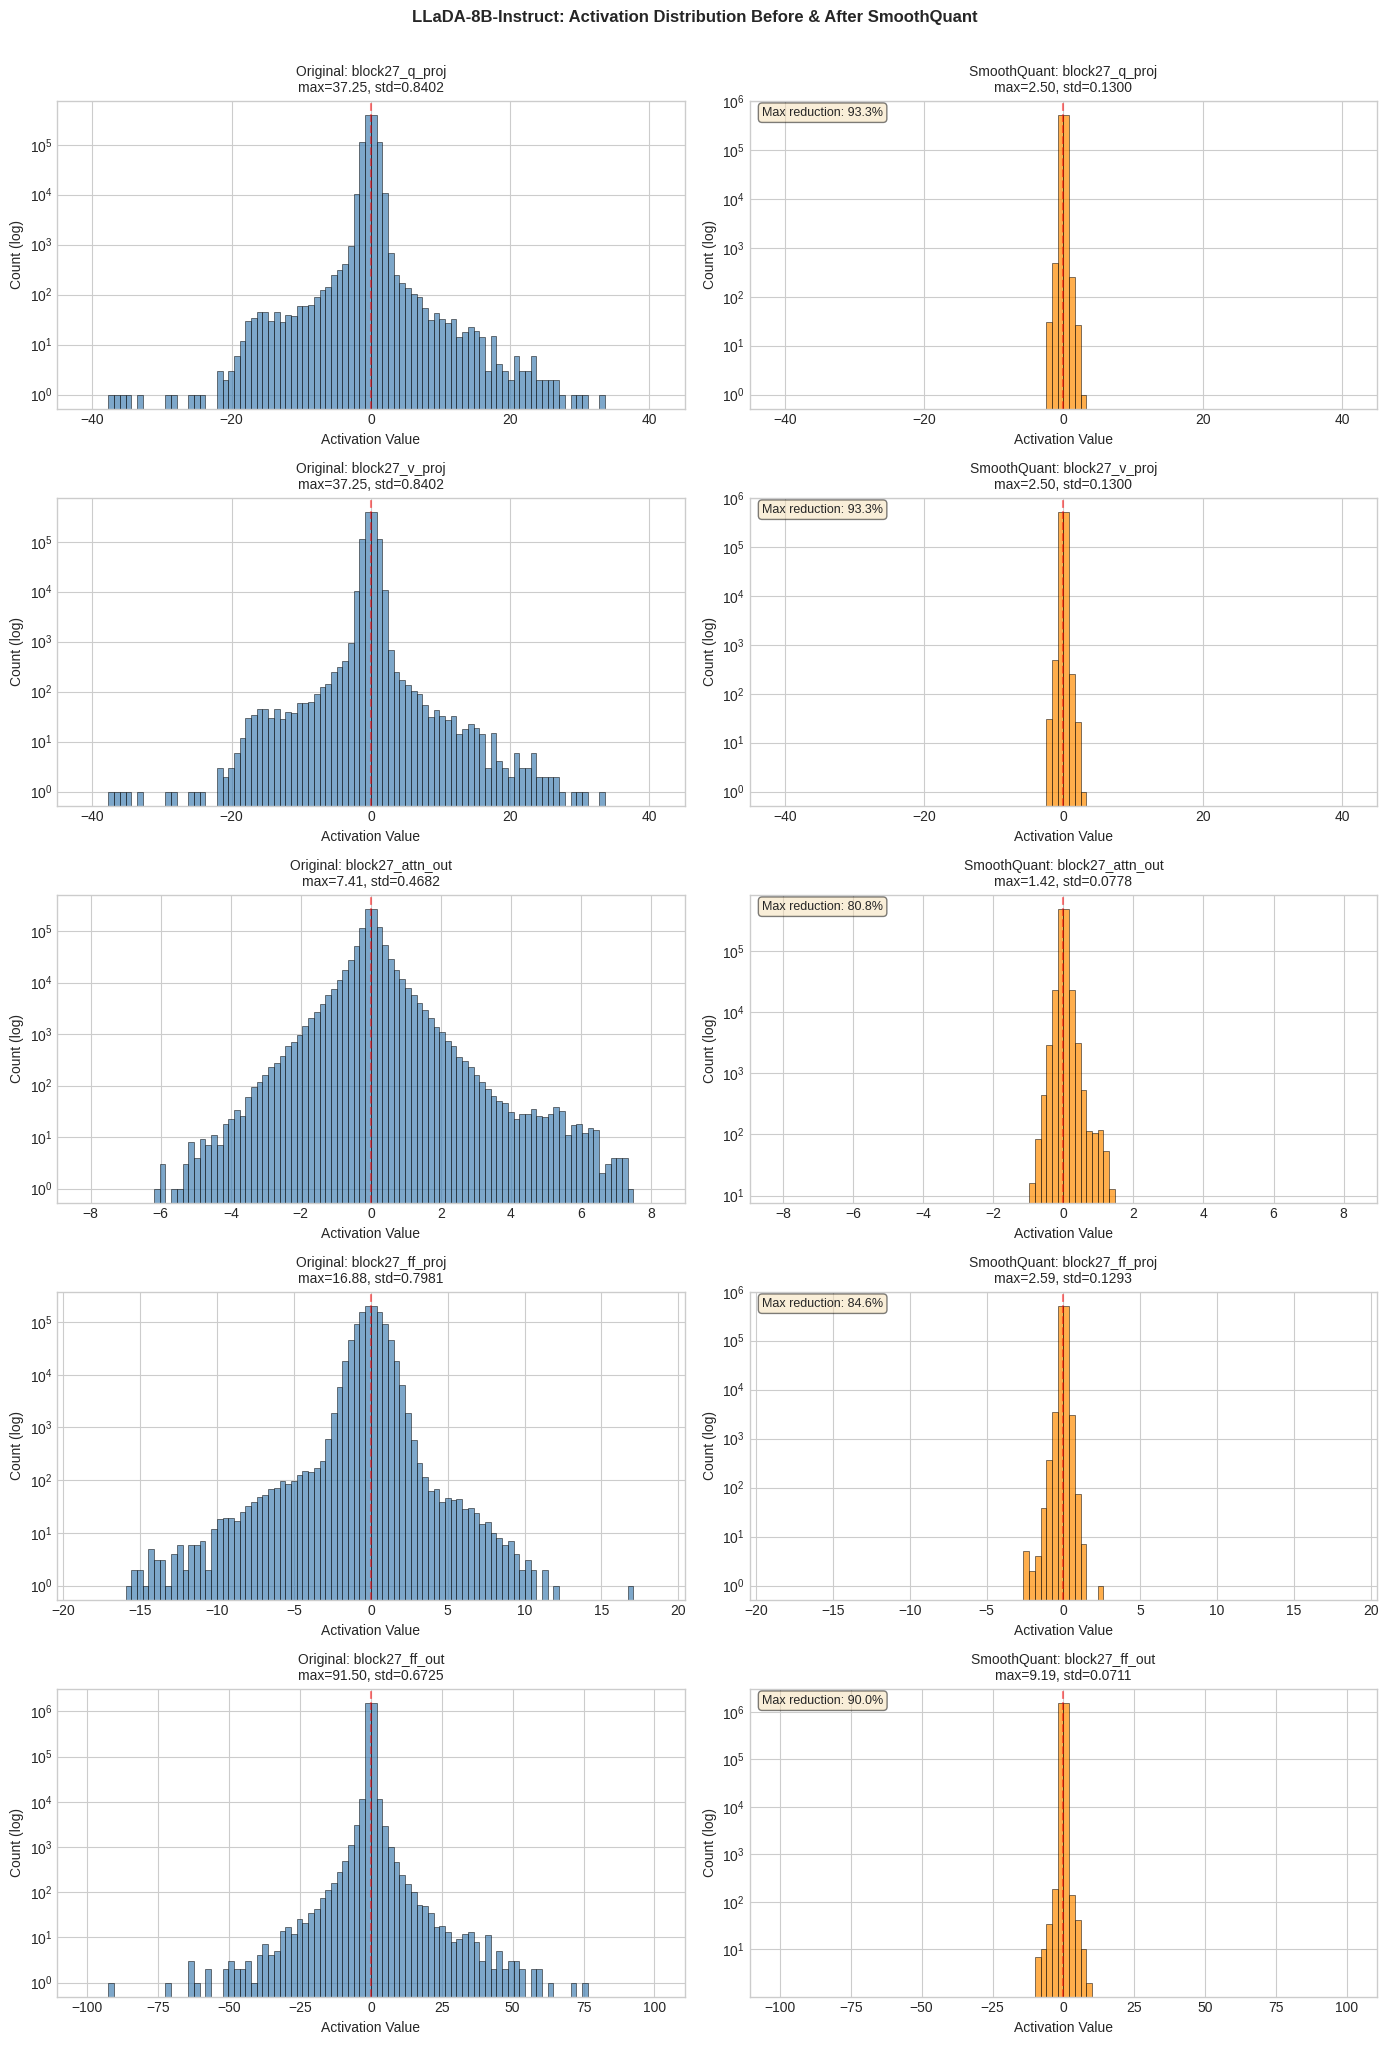

In [8]:
def plot_activation_histograms(
    original_acts: Dict[str, torch.Tensor],
    smoothquant_acts: Dict[str, torch.Tensor],
    layer_names: Optional[List[str]] = None,
    bins: int = 100,
    log_scale: bool = True,
):
    """
    Plot side-by-side histograms comparing activation distributions.
    
    Args:
        original_acts: Activations from original model
        smoothquant_acts: Activations from SmoothQuant model
        layer_names: Specific layers to plot (None = all)
        bins: Number of histogram bins
        log_scale: Whether to use log scale for y-axis
    """
    if layer_names is None:
        layer_names = list(original_acts.keys())
    
    n_layers = len(layer_names)
    fig, axes = plt.subplots(n_layers, 2, figsize=(14, 4 * n_layers), dpi=FIGURE_DPI)
    
    if n_layers == 1:
        axes = axes.reshape(1, -1)
    
    for i, name in enumerate(layer_names):
        orig = original_acts[name].float().flatten().numpy()
        sq = smoothquant_acts[name].float().flatten().numpy()
        
        # Compute statistics
        orig_max = np.abs(orig).max()
        sq_max = np.abs(sq).max()
        orig_std = orig.std()
        sq_std = sq.std()
        
        # Determine shared x-axis range
        x_max = max(orig_max, sq_max) * 1.1
        x_range = (-x_max, x_max)
        
        # Original histogram
        axes[i, 0].hist(orig, bins=bins, range=x_range, alpha=0.7, color='steelblue', edgecolor='black', linewidth=0.5)
        axes[i, 0].set_title(f"Original: {name}\nmax={orig_max:.2f}, std={orig_std:.4f}", fontsize=10)
        axes[i, 0].set_xlabel("Activation Value")
        axes[i, 0].set_ylabel("Count" + (" (log)" if log_scale else ""))
        if log_scale:
            axes[i, 0].set_yscale('log')
        axes[i, 0].axvline(x=0, color='red', linestyle='--', alpha=0.5)
        
        # SmoothQuant histogram
        axes[i, 1].hist(sq, bins=bins, range=x_range, alpha=0.7, color='darkorange', edgecolor='black', linewidth=0.5)
        axes[i, 1].set_title(f"SmoothQuant: {name}\nmax={sq_max:.2f}, std={sq_std:.4f}", fontsize=10)
        axes[i, 1].set_xlabel("Activation Value")
        axes[i, 1].set_ylabel("Count" + (" (log)" if log_scale else ""))
        if log_scale:
            axes[i, 1].set_yscale('log')
        axes[i, 1].axvline(x=0, color='red', linestyle='--', alpha=0.5)
        
        # Add reduction info
        reduction = (1 - sq_max / orig_max) * 100 if orig_max > 0 else 0
        axes[i, 1].text(0.02, 0.98, f"Max reduction: {reduction:.1f}%", 
                       transform=axes[i, 1].transAxes, fontsize=9,
                       verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.suptitle("LLaDA-8B-Instruct: Activation Distribution Before & After SmoothQuant", 
                 fontsize=12, fontweight='bold', y=1.02)
    plt.show()


# Plot histograms for all captured layers
plot_activation_histograms(original_activations, smoothquant_activations, bins=HIST_BINS)

## Visualization 2: Per-Channel Maximum Activations

This visualization shows the maximum activation value for each channel. SmoothQuant aims to reduce outlier channels that have disproportionately high activation magnitudes.

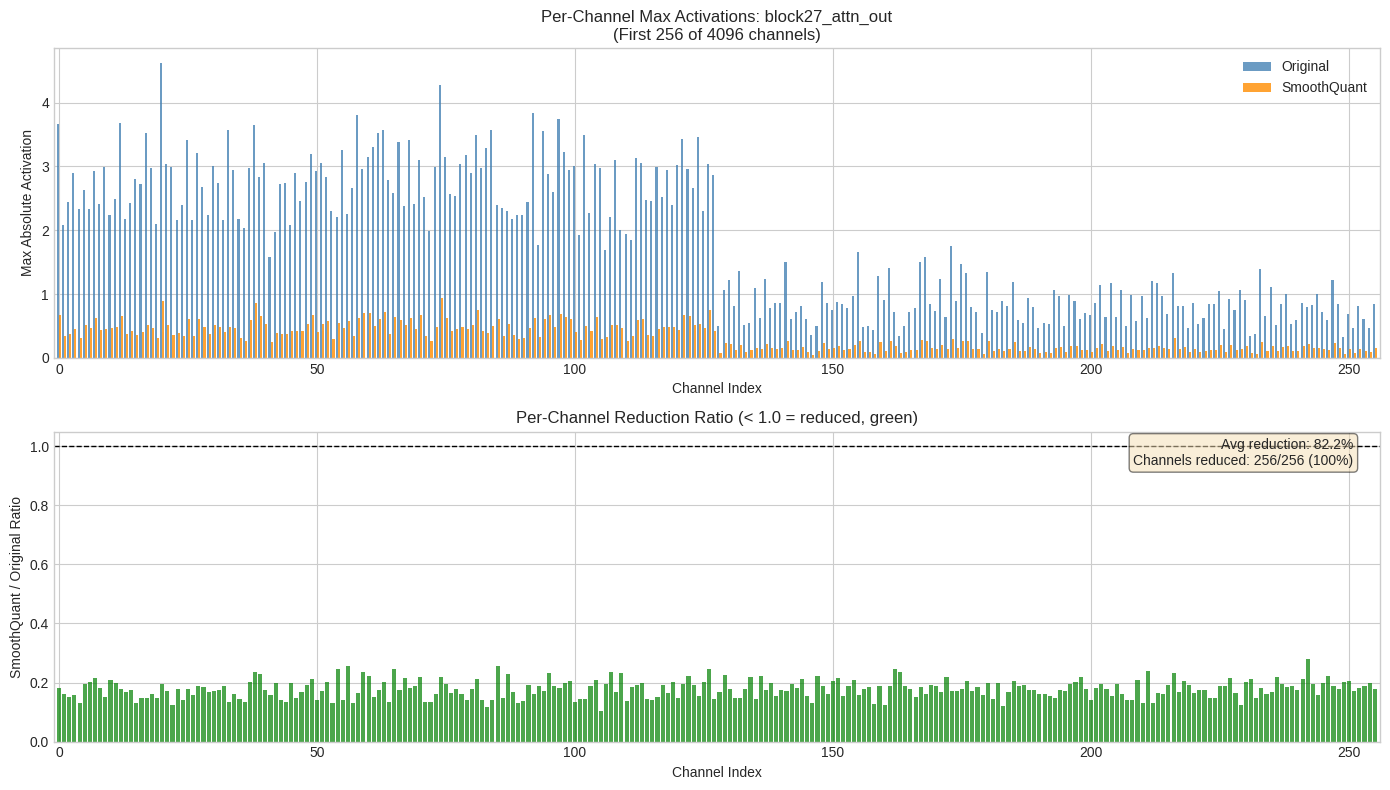

In [9]:
def plot_per_channel_max(
    original_acts: Dict[str, torch.Tensor],
    smoothquant_acts: Dict[str, torch.Tensor],
    layer_name: str,
    num_channels: int = 256,  # Show subset for readability
):
    """
    Plot per-channel maximum activation values before and after SmoothQuant.
    
    Args:
        original_acts: Activations from original model
        smoothquant_acts: Activations from SmoothQuant model  
        layer_name: Name of the layer to visualize
        num_channels: Number of channels to display (uses first N)
    """
    orig = original_acts[layer_name].float()
    sq = smoothquant_acts[layer_name].float()
    
    # Reshape to (batch * seq_len, hidden_dim) and compute per-channel max
    orig_flat = orig.view(-1, orig.shape[-1])
    sq_flat = sq.view(-1, sq.shape[-1])
    
    orig_channel_max = orig_flat.abs().max(dim=0)[0].numpy()
    sq_channel_max = sq_flat.abs().max(dim=0)[0].numpy()
    
    # Limit to num_channels for visualization
    total_channels = len(orig_channel_max)
    if num_channels > total_channels:
        num_channels = total_channels
    
    channels = np.arange(num_channels)
    orig_subset = orig_channel_max[:num_channels]
    sq_subset = sq_channel_max[:num_channels]
    
    # Create figure
    fig, axes = plt.subplots(2, 1, figsize=(14, 8), dpi=FIGURE_DPI)
    
    # Bar plot comparison
    width = 0.4
    axes[0].bar(channels - width/2, orig_subset, width, label='Original', color='steelblue', alpha=0.8)
    axes[0].bar(channels + width/2, sq_subset, width, label='SmoothQuant', color='darkorange', alpha=0.8)
    axes[0].set_xlabel("Channel Index")
    axes[0].set_ylabel("Max Absolute Activation")
    axes[0].set_title(f"Per-Channel Max Activations: {layer_name}\n(First {num_channels} of {total_channels} channels)")
    axes[0].legend()
    axes[0].set_xlim(-1, num_channels)
    
    # Ratio plot (smoothquant / original)
    ratio = sq_subset / (orig_subset + 1e-8)
    colors = ['green' if r < 1 else 'red' for r in ratio]
    axes[1].bar(channels, ratio, color=colors, alpha=0.7)
    axes[1].axhline(y=1.0, color='black', linestyle='--', linewidth=1)
    axes[1].set_xlabel("Channel Index")
    axes[1].set_ylabel("SmoothQuant / Original Ratio")
    axes[1].set_title("Per-Channel Reduction Ratio (< 1.0 = reduced, green)")
    axes[1].set_xlim(-1, num_channels)
    
    # Add statistics
    avg_reduction = (1 - ratio.mean()) * 100
    channels_reduced = (ratio < 1).sum()
    stats_text = f"Avg reduction: {avg_reduction:.1f}%\nChannels reduced: {channels_reduced}/{num_channels} ({channels_reduced/num_channels*100:.0f}%)"
    axes[1].text(0.98, 0.98, stats_text, transform=axes[1].transAxes, fontsize=10,
                verticalalignment='top', horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.show()
    
    return orig_channel_max, sq_channel_max


# Plot for attn_out (the example mentioned by user)
layer_to_visualize = "block27_attn_out"
if layer_to_visualize in original_activations:
    orig_max, sq_max = plot_per_channel_max(
        original_activations, 
        smoothquant_activations, 
        layer_to_visualize,
        num_channels=256
    )
else:
    # Use first available layer
    first_layer = list(original_activations.keys())[0]
    print(f"Layer {layer_to_visualize} not found, using {first_layer}")
    orig_max, sq_max = plot_per_channel_max(
        original_activations, 
        smoothquant_activations, 
        first_layer,
        num_channels=256
    )

## Visualization 3: Activation Heatmaps

2D heatmaps showing the activation tensor values. This provides a spatial view of how activations are distributed across sequence positions and channels.

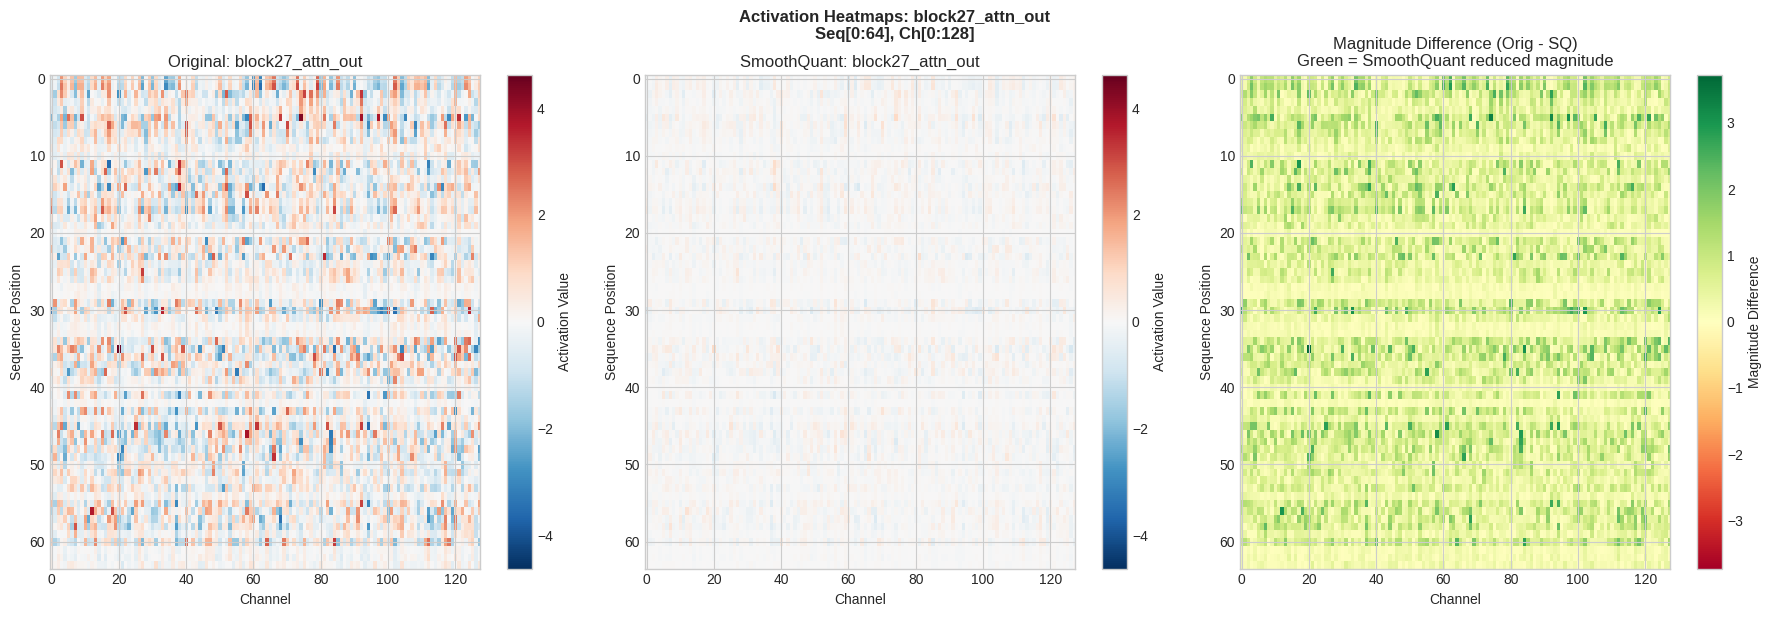

In [10]:
def plot_activation_heatmaps(
    original_acts: Dict[str, torch.Tensor],
    smoothquant_acts: Dict[str, torch.Tensor],
    layer_name: str,
    seq_range: Tuple[int, int] = (0, 64),
    channel_range: Tuple[int, int] = (0, 128),
):
    """
    Plot 2D heatmaps of activation tensors.
    
    Args:
        original_acts: Activations from original model
        smoothquant_acts: Activations from SmoothQuant model
        layer_name: Name of the layer to visualize
        seq_range: Range of sequence positions to show
        channel_range: Range of channels to show
    """
    orig = original_acts[layer_name].float()[0]  # Remove batch dim
    sq = smoothquant_acts[layer_name].float()[0]
    
    # Extract subset for visualization
    seq_start, seq_end = seq_range
    ch_start, ch_end = channel_range
    
    orig_subset = orig[seq_start:seq_end, ch_start:ch_end].numpy()
    sq_subset = sq[seq_start:seq_end, ch_start:ch_end].numpy()
    
    # Compute shared color scale
    vmax = max(np.abs(orig_subset).max(), np.abs(sq_subset).max())
    vmin = -vmax
    
    # Create figure
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), dpi=FIGURE_DPI)
    
    # Original heatmap
    im0 = axes[0].imshow(orig_subset, aspect='auto', cmap='RdBu_r', vmin=vmin, vmax=vmax)
    axes[0].set_title(f"Original: {layer_name}")
    axes[0].set_xlabel("Channel")
    axes[0].set_ylabel("Sequence Position")
    plt.colorbar(im0, ax=axes[0], label="Activation Value")
    
    # SmoothQuant heatmap
    im1 = axes[1].imshow(sq_subset, aspect='auto', cmap='RdBu_r', vmin=vmin, vmax=vmax)
    axes[1].set_title(f"SmoothQuant: {layer_name}")
    axes[1].set_xlabel("Channel")
    axes[1].set_ylabel("Sequence Position")
    plt.colorbar(im1, ax=axes[1], label="Activation Value")
    
    # Difference heatmap
    diff = np.abs(orig_subset) - np.abs(sq_subset)  # Positive = original has larger magnitude
    diff_max = np.abs(diff).max()
    im2 = axes[2].imshow(diff, aspect='auto', cmap='RdYlGn', vmin=-diff_max, vmax=diff_max)
    axes[2].set_title(f"Magnitude Difference (Orig - SQ)\nGreen = SmoothQuant reduced magnitude")
    axes[2].set_xlabel("Channel")
    axes[2].set_ylabel("Sequence Position")
    plt.colorbar(im2, ax=axes[2], label="Magnitude Difference")
    
    plt.tight_layout()
    plt.suptitle(f"Activation Heatmaps: {layer_name}\nSeq[{seq_start}:{seq_end}], Ch[{ch_start}:{ch_end}]", 
                 fontsize=12, fontweight='bold', y=1.02)
    plt.show()


# Plot heatmaps for attn_out
layer_to_visualize = "block27_attn_out"
if layer_to_visualize in original_activations:
    plot_activation_heatmaps(
        original_activations, 
        smoothquant_activations, 
        layer_to_visualize,
        seq_range=(0, 64),
        channel_range=(0, 128)
    )
else:
    first_layer = list(original_activations.keys())[0]
    print(f"Layer {layer_to_visualize} not found, using {first_layer}")
    plot_activation_heatmaps(
        original_activations, 
        smoothquant_activations, 
        first_layer,
        seq_range=(0, 64),
        channel_range=(0, 128)
    )

## Visualization 4: Quantization Error Comparison

This visualization demonstrates the core benefit of SmoothQuant: reduced quantization error. We simulate INT8 quantization on both the original and smoothed activations and compare the resulting errors.

Computing INT8 quantization errors...

Layer                     Original MSE    SmoothQuant MSE    MSE Reduction  
---------------------------------------------------------------------------
block27_q_proj            0.007147        0.000032           99.5           %
block27_v_proj            0.007147        0.000032           99.5           %
block27_attn_out          0.000283        0.000010           96.3           %
block27_ff_proj           0.001472        0.000035           97.6           %
block27_ff_out            0.031518        0.000268           99.1           %


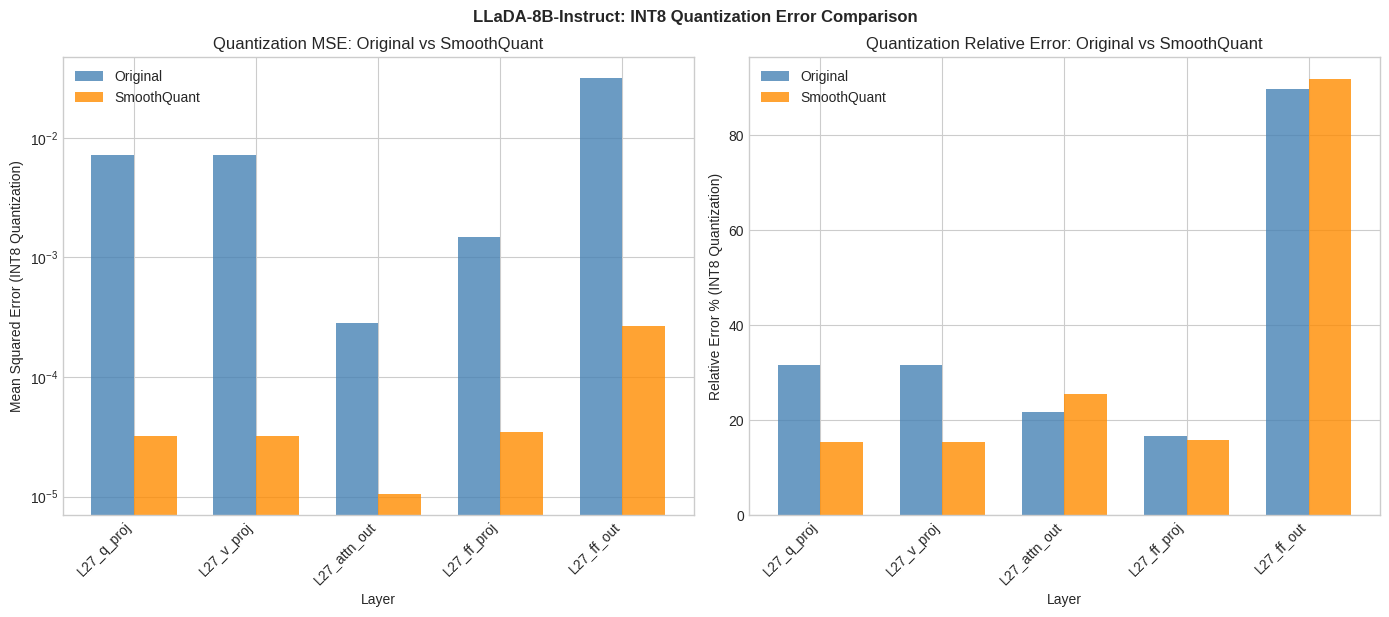


Average MSE reduction: 99.2%
Original avg MSE: 0.009513
SmoothQuant avg MSE: 0.000076


In [11]:
def compute_quantization_error(
    tensor: torch.Tensor,
    n_bits: int = 8,
    per_channel: bool = False,
) -> Tuple[float, float, torch.Tensor]:
    """
    Compute quantization error (MSE and relative error) for a tensor.
    
    Args:
        tensor: Input tensor to quantize
        n_bits: Number of bits for quantization
        per_channel: Whether to use per-channel quantization
    
    Returns:
        Tuple of (MSE, relative error, quantized tensor)
    """
    tensor_float = tensor.float()
    
    # Apply quantization
    quantized = quantize_tensor(tensor_float, n_bits=n_bits, per_channel=per_channel)
    
    # Compute errors
    mse = ((tensor_float - quantized) ** 2).mean().item()
    rel_error = (torch.abs(tensor_float - quantized) / (torch.abs(tensor_float) + 1e-8)).mean().item()
    
    return mse, rel_error, quantized


def plot_quantization_errors(
    original_acts: Dict[str, torch.Tensor],
    smoothquant_acts: Dict[str, torch.Tensor],
    n_bits: int = 8,
):
    """
    Compare quantization errors before and after SmoothQuant.
    
    Args:
        original_acts: Activations from original model
        smoothquant_acts: Activations from SmoothQuant model
        n_bits: Number of bits for quantization
    """
    layer_names = list(original_acts.keys())
    
    orig_mses = []
    sq_mses = []
    orig_rel_errors = []
    sq_rel_errors = []
    
    print(f"Computing INT{n_bits} quantization errors...\n")
    print(f"{'Layer':<25} {'Original MSE':<15} {'SmoothQuant MSE':<18} {'MSE Reduction':<15}")
    print("-" * 75)
    
    for name in layer_names:
        orig_mse, orig_rel, _ = compute_quantization_error(original_acts[name], n_bits=n_bits)
        sq_mse, sq_rel, _ = compute_quantization_error(smoothquant_acts[name], n_bits=n_bits)
        
        orig_mses.append(orig_mse)
        sq_mses.append(sq_mse)
        orig_rel_errors.append(orig_rel * 100)
        sq_rel_errors.append(sq_rel * 100)
        
        reduction = (1 - sq_mse / orig_mse) * 100 if orig_mse > 0 else 0
        print(f"{name:<25} {orig_mse:<15.6f} {sq_mse:<18.6f} {reduction:<15.1f}%")
    
    # Create visualization
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), dpi=FIGURE_DPI)
    
    x = np.arange(len(layer_names))
    width = 0.35
    
    # MSE comparison
    axes[0].bar(x - width/2, orig_mses, width, label='Original', color='steelblue', alpha=0.8)
    axes[0].bar(x + width/2, sq_mses, width, label='SmoothQuant', color='darkorange', alpha=0.8)
    axes[0].set_xlabel("Layer")
    axes[0].set_ylabel(f"Mean Squared Error (INT{n_bits} Quantization)")
    axes[0].set_title(f"Quantization MSE: Original vs SmoothQuant")
    axes[0].set_xticks(x)
    axes[0].set_xticklabels([n.replace('block27_', 'L27_') for n in layer_names], rotation=45, ha='right')
    axes[0].legend()
    axes[0].set_yscale('log')
    
    # Relative error comparison
    axes[1].bar(x - width/2, orig_rel_errors, width, label='Original', color='steelblue', alpha=0.8)
    axes[1].bar(x + width/2, sq_rel_errors, width, label='SmoothQuant', color='darkorange', alpha=0.8)
    axes[1].set_xlabel("Layer")
    axes[1].set_ylabel(f"Relative Error % (INT{n_bits} Quantization)")
    axes[1].set_title(f"Quantization Relative Error: Original vs SmoothQuant")
    axes[1].set_xticks(x)
    axes[1].set_xticklabels([n.replace('block27_', 'L27_') for n in layer_names], rotation=45, ha='right')
    axes[1].legend()
    
    plt.tight_layout()
    plt.suptitle(f"LLaDA-8B-Instruct: INT{n_bits} Quantization Error Comparison", 
                 fontsize=12, fontweight='bold', y=1.02)
    plt.show()
    
    # Summary statistics
    avg_orig_mse = np.mean(orig_mses)
    avg_sq_mse = np.mean(sq_mses)
    avg_reduction = (1 - avg_sq_mse / avg_orig_mse) * 100
    print(f"\n{'='*50}")
    print(f"Average MSE reduction: {avg_reduction:.1f}%")
    print(f"Original avg MSE: {avg_orig_mse:.6f}")
    print(f"SmoothQuant avg MSE: {avg_sq_mse:.6f}")
    

# Plot quantization error comparison
plot_quantization_errors(original_activations, smoothquant_activations, n_bits=8)

## Visualization 5: 3D Activation Surface

This visualization creates a 3D surface plot showing how activation values vary across both token positions (sequence) and channels (hidden dimension). The vertical axis represents activation magnitude, giving an intuitive view of activation "peaks" and "valleys" across the tensor dimensions.

Note: For computational efficiency and visual clarity, we subsample both the token and channel dimensions.

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

def plot_3d_activation_surface(
    original_act: torch.Tensor,
    smoothquant_act: torch.Tensor,
    layer_name: str,
    token_subsample: int = 8,
    channel_subsample: int = 64,
    figsize: Tuple[int, int] = (16, 6),
):
    """
    Create 3D surface plots comparing original and smoothquant activations.
    
    Args:
        original_act: Original activation tensor [batch, tokens, channels]
        smoothquant_act: SmoothQuant activation tensor [batch, tokens, channels]
        layer_name: Name of the layer for the title
        token_subsample: Subsample every N tokens for clarity
        channel_subsample: Subsample every N channels for clarity
        figsize: Figure size
    """
    # Extract first batch and convert to numpy
    orig = original_act[0].float().numpy()
    sq = smoothquant_act[0].float().numpy()
    
    num_tokens, num_channels = orig.shape
    
    # Subsample for visualization
    token_indices = np.arange(0, num_tokens, token_subsample)
    channel_indices = np.arange(0, num_channels, channel_subsample)
    
    orig_sub = orig[np.ix_(token_indices, channel_indices)]
    sq_sub = sq[np.ix_(token_indices, channel_indices)]
    
    # Create meshgrid for 3D plotting
    channels, tokens = np.meshgrid(channel_indices, token_indices)
    
    # Create figure with two 3D subplots
    fig = plt.figure(figsize=figsize)
    
    # Original activations
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    surf1 = ax1.plot_surface(
        channels, tokens, orig_sub,
        cmap='viridis',
        alpha=0.8,
        edgecolor='none'
    )
    ax1.set_xlabel('Channel', fontsize=10)
    ax1.set_ylabel('Token Position', fontsize=10)
    ax1.set_zlabel('Activation', fontsize=10)
    ax1.set_title(f'Original: {layer_name}', fontsize=12, fontweight='bold')
    ax1.view_init(elev=25, azim=45)
    fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=10, label='Activation')
    
    # SmoothQuant activations
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    surf2 = ax2.plot_surface(
        channels, tokens, sq_sub,
        cmap='plasma',
        alpha=0.8,
        edgecolor='none'
    )
    ax2.set_xlabel('Channel', fontsize=10)
    ax2.set_ylabel('Token Position', fontsize=10)
    ax2.set_zlabel('Activation', fontsize=10)
    ax2.set_title(f'SmoothQuant: {layer_name}', fontsize=12, fontweight='bold')
    ax2.view_init(elev=25, azim=45)
    fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=10, label='Activation')
    
    plt.suptitle(
        f'3D Activation Surface: Channel × Token × Activation\n'
        f'(Subsampled: every {token_subsample} tokens, every {channel_subsample} channels)',
        fontsize=14, fontweight='bold', y=1.02
    )
    plt.tight_layout()
    plt.show()
    
    # Print stats
    print(f"\n{layer_name} Activation Statistics:")
    print(f"  Original  - Mean: {orig.mean():.4f}, Std: {orig.std():.4f}, "
          f"Max: {orig.max():.4f}, Min: {orig.min():.4f}")
    print(f"  SmoothQuant - Mean: {sq.mean():.4f}, Std: {sq.std():.4f}, "
          f"Max: {sq.max():.4f}, Min: {sq.min():.4f}")


# Plot 3D surface for each captured layer
for layer_name in original_activations.keys():
    orig_act = original_activations[layer_name]
    sq_act = smoothquant_activations[layer_name]
    
    # Adjust subsampling based on layer size
    num_channels = orig_act.shape[-1]
    channel_step = max(1, num_channels // 64)  # Aim for ~64 channel points
    
    plot_3d_activation_surface(
        orig_act, sq_act, layer_name,
        token_subsample=4,  # Every 4th token
        channel_subsample=channel_step,
    )
    print("-" * 80)

## Summary

This notebook demonstrates the effect of SmoothQuant on LLaDA model activations:

1. **Histogram Analysis**: Shows how SmoothQuant reduces activation outliers and narrows the distribution range
2. **Per-Channel Analysis**: Reveals which channels have reduced magnitude after smoothing
3. **Heatmap Visualization**: Provides spatial view of activation changes
4. **Quantization Error**: Quantifies the improvement in INT8 quantization accuracy

The key takeaway is that SmoothQuant successfully migrates quantization difficulty from activations to weights, resulting in lower quantization error and better model accuracy when using INT8 quantization.

## Explore Other Layers

Use the cell below to visualize any of the captured layers. Modify `layer_to_explore` to see different layers.

Available layers:
  0: block27_q_proj
  1: block27_v_proj
  2: block27_attn_out
  3: block27_ff_proj
  4: block27_ff_out

Exploring: block27_q_proj

1. Per-Channel Max Activations:


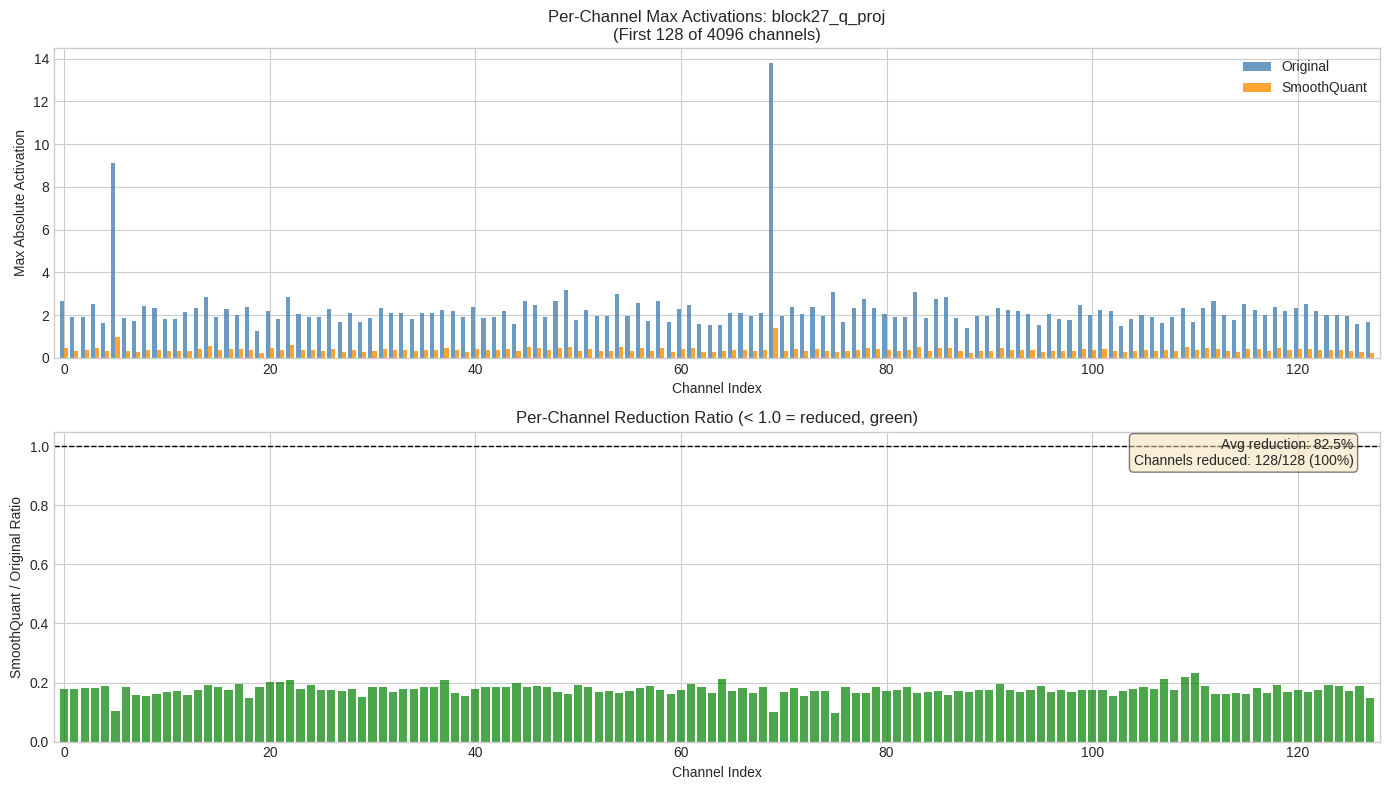


2. Activation Heatmaps:


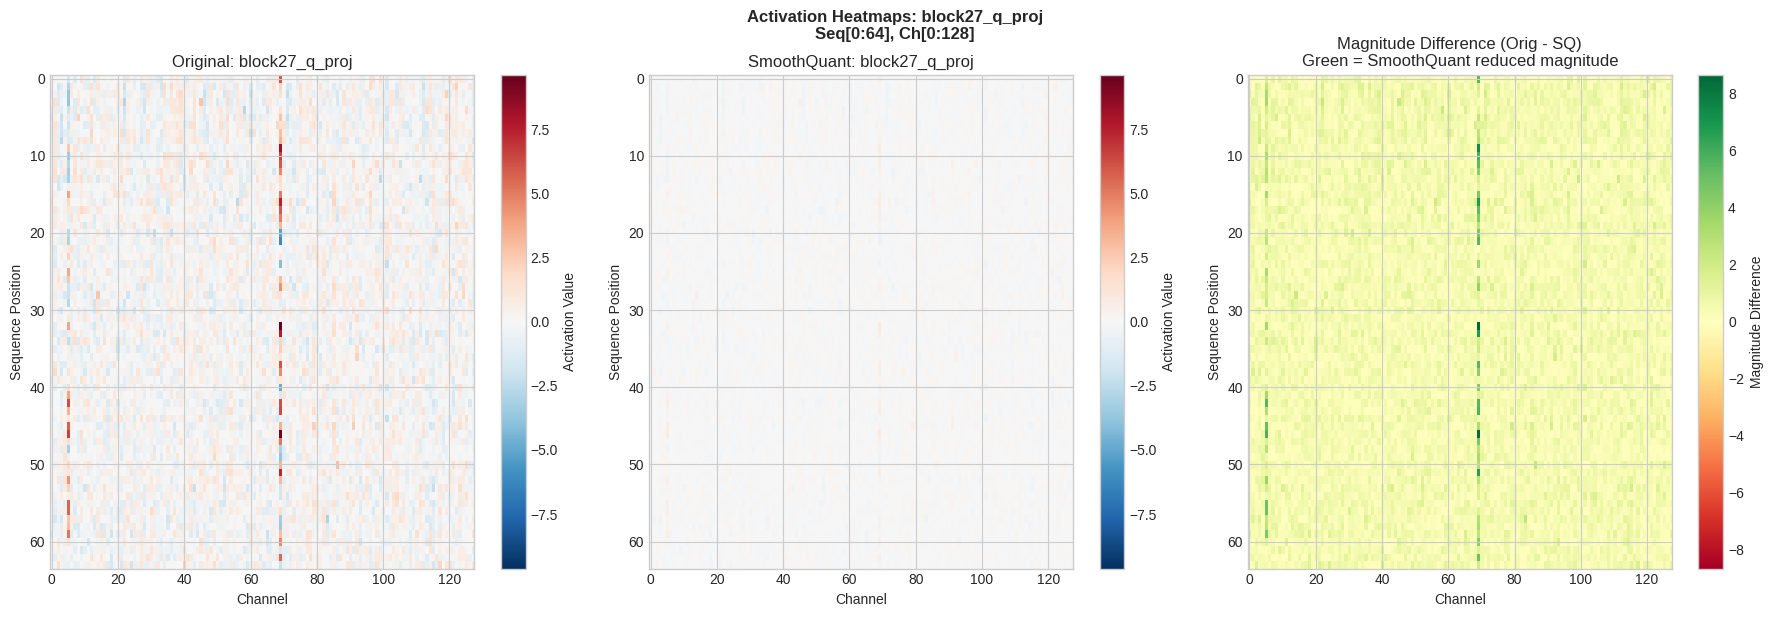


3. Activation Distribution:


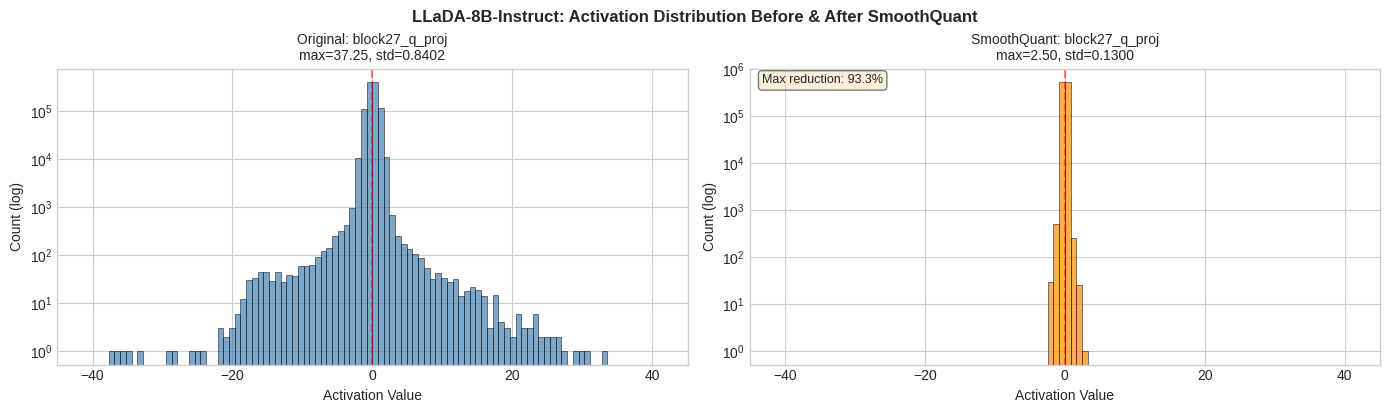

In [12]:
# Interactive exploration - change this variable to explore different layers
print("Available layers:")
for i, name in enumerate(original_activations.keys()):
    print(f"  {i}: {name}")

# Select a layer to explore (change this index to explore different layers)
layer_idx = 0
layer_to_explore = list(original_activations.keys())[layer_idx]

print(f"\nExploring: {layer_to_explore}")
print("=" * 50)

# Generate all visualizations for the selected layer
print("\n1. Per-Channel Max Activations:")
plot_per_channel_max(original_activations, smoothquant_activations, layer_to_explore, num_channels=128)

print("\n2. Activation Heatmaps:")
plot_activation_heatmaps(original_activations, smoothquant_activations, layer_to_explore)

print("\n3. Activation Distribution:")
plot_activation_histograms(original_activations, smoothquant_activations, layer_names=[layer_to_explore])